In [1]:
import tensorflow as tf
import os
import random

2025-07-07 13:48:09.592280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751896090.015503      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751896090.134289      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_root = "/kaggle/input/meei-yfp-biner-2"

In [3]:
pip install imgaug opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 13.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from imgaug import augmenters as iaa
import random
from tqdm import tqdm

# Parameter

class_names = ['Normal', 'Paralysis']
target_images_per_class = 500  # Total gambar yang ingin dihasilkan per kelas
img_size = (224, 224)

# Folder output untuk hasil augmentasi
augmented_root = 'augmented_datasetCropMEIYFP1000'
os.makedirs(augmented_root, exist_ok=True)

# Augmentasi

augmenter = iaa.Sequential([
    # Horizontal Flip
    iaa.Fliplr(0.5),

    # Rotation hingga ±20 derajat (20%)
    iaa.Affine(rotate=(-20, 20)),

    # Shear hingga ±20%
    iaa.Affine(shear=(-20, 20)),

    # Zoom in/out hingga ±20%
    iaa.Affine(scale=(0.8, 1.2))
])

print("🔁 Mulai augmentasi gambar...")
for class_name in class_names:
    class_input_dir = os.path.join(data_root, class_name)
    class_output_dir = os.path.join(augmented_root, class_name)
    os.makedirs(class_output_dir, exist_ok=True)

    # Ambil semua gambar asli
    image_files = [f for f in os.listdir(class_input_dir) if f.lower().endswith(('.jpg', '.png', '.bmp'))]
    images = []

    for file in image_files:
        img_path = os.path.join(class_input_dir, file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        images.append(img)

        # Simpan juga gambar asli
        filename = os.path.join(class_output_dir, file)
        cv2.imwrite(filename, img)

    # Tambah augmentasi sampai total = target_images_per_class
    count = len(images)
    idx = 0
    while count < target_images_per_class:
        img = images[idx % len(images)]
        augmented_img = augmenter(image=img)
        filename = os.path.join(class_output_dir, f'aug_{count+1:03d}.jpg')
        cv2.imwrite(filename, augmented_img)
        count += 1
        idx += 1

print("✅ Augmentasi selesai. Dataset tersedia di:", augmented_root)

# -------------------------------------------------------------------------------------------------
# Setelah augmentasi, lanjut buat dataset pipeline seperti sebelumnya

print("📦 Membuat dataset pipeline...")

# Gunakan dataset hasil augmentasi
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    augmented_root,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    image_size=img_size,
    batch_size=None,  # Per gambar
    shuffle=True
)

# Normalisasi
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image, label


full_dataset = full_dataset.map(preprocess)

# Hitung total
total_size = sum(1 for _ in full_dataset)
print("Total images:", total_size)

# Ubah ke list lalu split
full_dataset_list = list(full_dataset)
random.shuffle(full_dataset_list)

train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

images = [x[0] for x in full_dataset_list]
labels = [x[1] for x in full_dataset_list]

train_images = images[:train_size]
train_labels = labels[:train_size]

val_images = images[train_size:train_size+val_size]
val_labels = labels[train_size:train_size+val_size]

test_images = images[train_size+val_size:]
test_labels = labels[train_size+val_size:]

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print(f"✅ Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

🔁 Mulai augmentasi gambar...
✅ Augmentasi selesai. Dataset tersedia di: augmented_datasetCropMEIYFP1000
📦 Membuat dataset pipeline...
Found 1000 files belonging to 2 classes.


I0000 00:00:1751896125.701543      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751896125.702303      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Total images: 1000
✅ Train size: 700, Validation size: 200, Test size: 100


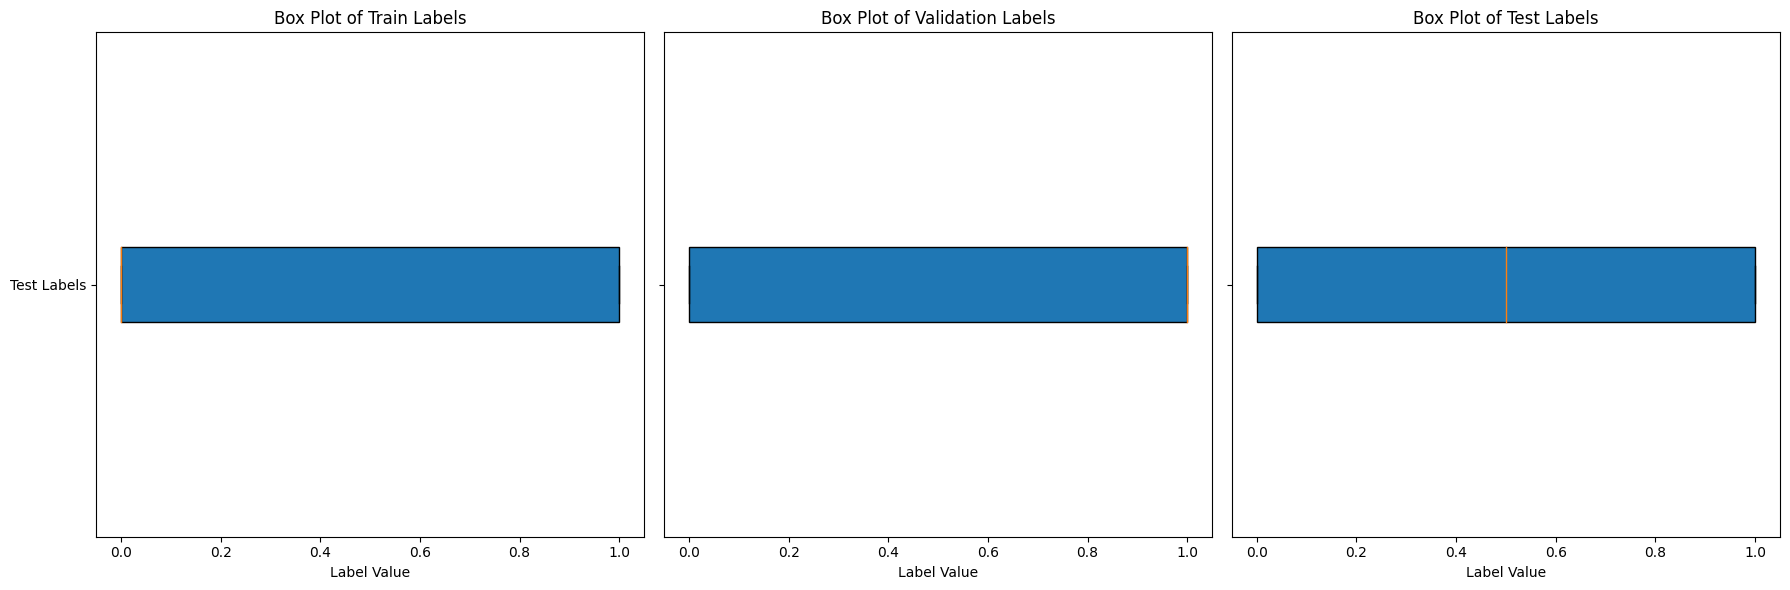

In [5]:
import matplotlib.pyplot as plt
# Fungsi untuk mengumpulkan semua label dari tf.data.Dataset ke list
def collect_labels(dataset):
    labels = []
    for _, batch_labels in dataset:
        labels.extend(batch_labels.numpy().tolist())
    return labels

# Kumpulkan semua label dari dataset train, val, test
all_train_labels = collect_labels(train_dataset)
all_val_labels = collect_labels(val_dataset)
all_test_labels = collect_labels(test_dataset)

# Buat boxplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot untuk train labels
axes[0].boxplot(all_train_labels, vert=False, patch_artist=True)
axes[0].set_title("Box Plot of Train Labels")
axes[0].set_xlabel("Label Value")
axes[0].set_yticks([1])
axes[0].set_yticklabels(["Train Labels"])

# Plot untuk validation labels
axes[1].boxplot(all_val_labels, vert=False, patch_artist=True)
axes[1].set_title("Box Plot of Validation Labels")
axes[1].set_xlabel("Label Value")
axes[1].set_yticks([1])
axes[1].set_yticklabels(["Validation Labels"])

# Plot untuk test labels
axes[2].boxplot(all_test_labels, vert=False, patch_artist=True)
axes[2].set_title("Box Plot of Test Labels")
axes[2].set_xlabel("Label Value")
axes[2].set_yticks([1])
axes[2].set_yticklabels(["Test Labels"])

plt.tight_layout()
plt.show()

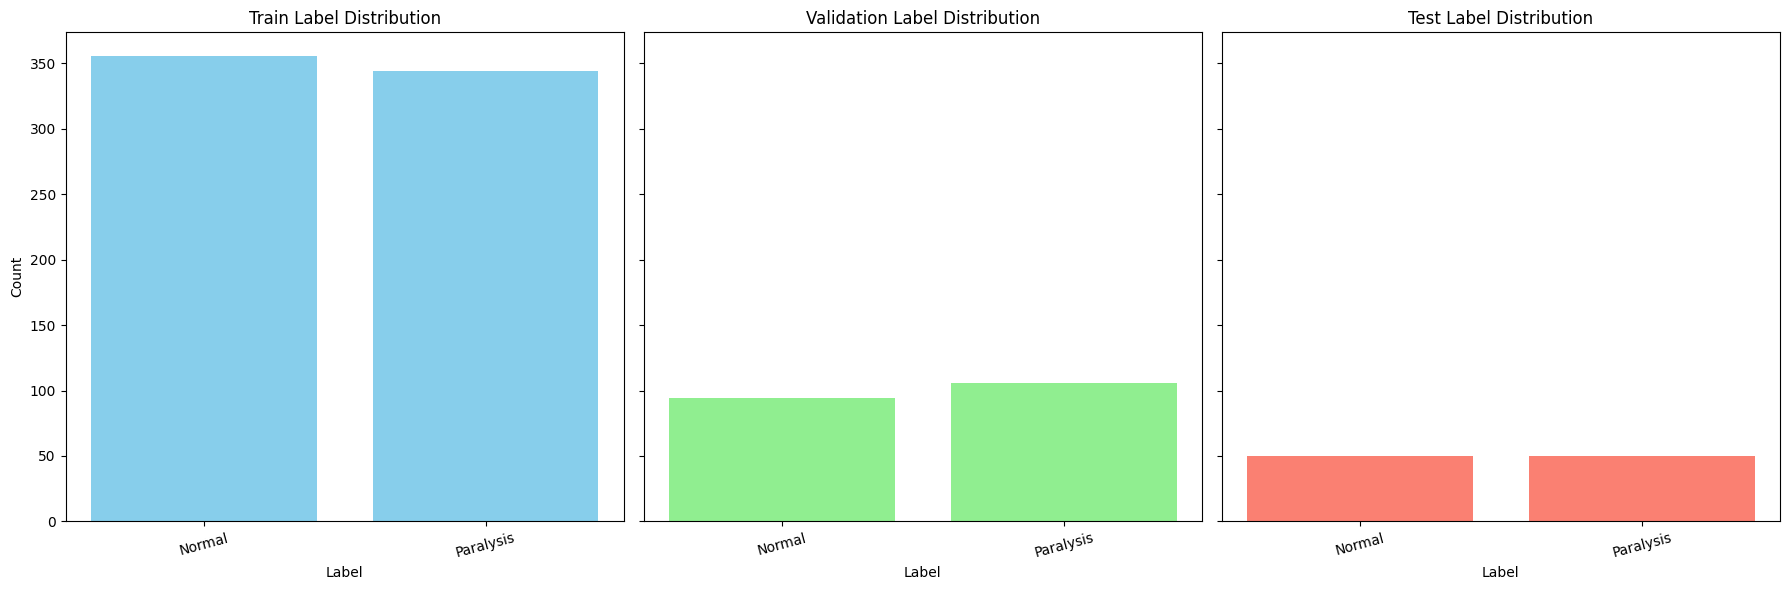

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

# Fungsi untuk mengumpulkan semua label dari tf.data.Dataset ke list
def collect_labels(dataset):
    labels = []
    for _, batch_labels in dataset:
        labels.extend(batch_labels.numpy().tolist())
    return labels

# Kumpulkan semua label dari dataset train, val, test
all_train_labels = collect_labels(train_dataset)
all_val_labels = collect_labels(val_dataset)
all_test_labels = collect_labels(test_dataset)

# Hitung jumlah masing-masing label
train_counts = Counter(all_train_labels)
val_counts = Counter(all_val_labels)
test_counts = Counter(all_test_labels)

# Daftar semua label unik (urutkan supaya konsisten)
all_labels = sorted(set(train_counts.keys()) | set(val_counts.keys()) | set(test_counts.keys()))

# Nama kelas jika ada (opsional, sesuai label 0,1,2,3)
class_names = ['Normal', 'Paralysis']

# Buat barplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Train
axes[0].bar(all_labels, [train_counts.get(l, 0) for l in all_labels], color='skyblue')
axes[0].set_title("Train Label Distribution")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Count")
axes[0].set_xticks(all_labels)
axes[0].set_xticklabels([class_names[l] for l in all_labels], rotation=15)

# Validation
axes[1].bar(all_labels, [val_counts.get(l, 0) for l in all_labels], color='lightgreen')
axes[1].set_title("Validation Label Distribution")
axes[1].set_xlabel("Label")
axes[1].set_xticks(all_labels)
axes[1].set_xticklabels([class_names[l] for l in all_labels], rotation=15)

# Test
axes[2].bar(all_labels, [test_counts.get(l, 0) for l in all_labels], color='salmon')
axes[2].set_title("Test Label Distribution")
axes[2].set_xlabel("Label")
axes[2].set_xticks(all_labels)
axes[2].set_xticklabels([class_names[l] for l in all_labels], rotation=15)

plt.tight_layout()
plt.show()

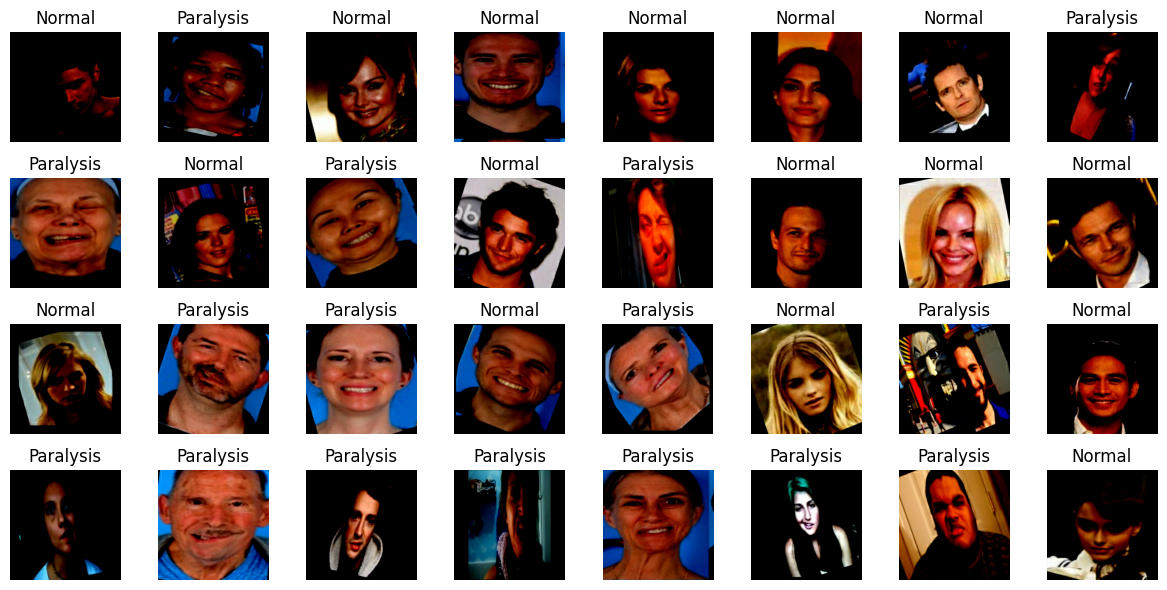

In [7]:
import numpy as np

# Fungsi untuk menampilkan batch gambar dalam grid
def imshow(images, labels, class_names):
    # images shape: (batch_size, height, width, channels)
    images = images.numpy()
    
    # Buat grid gambar (misal 4x8 gambar)
    grid_size = (4, 8)  # Sesuaikan dengan batch size jika perlu
    fig, axes = plt.subplots(*grid_size, figsize=(12,6))
    
    idx = 0
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if idx >= len(images):
                break
            ax = axes[i, j]
            img = images[idx]
            # Jika grayscale, hapus channel terakhir jika 1
            if img.shape[-1] == 1:
                img = img.squeeze(-1)
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            ax.axis('off')
            ax.set_title(class_names[labels[idx]])
            idx += 1
    
    plt.tight_layout()
    plt.show()

# Ambil satu batch data dari train_dataset (tf.data.Dataset)
for images, labels in train_dataset.take(1):
    imshow(images, labels.numpy(), class_names)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
import numpy as np
import pandas as pd
import os
from sklearn.metrics import precision_score, recall_score, f1_score

# === Setup kelas dan device ===
num_classes = 2  # binary classification

# === Load pretrained MobileNetV2 dari keras, tanpa top (classifier) ===
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # freeze pretrained layers

# === Tambahkan classifier akhir untuk klasifikasi biner ===
inputs = layers.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # 1 unit sigmoid for binary
model = models.Model(inputs, outputs)

# === Compile model ===
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.BinaryCrossentropy(),
    metrics=[
        metrics.BinaryAccuracy(name='accuracy')
    ]
)

# === Callback simpan model dan log csv ===
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.h5'),
        save_best_only=False,
        save_weights_only=False,
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger('training_log.csv')
]

# === Training dengan model.fit ===
num_epochs = 10
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=num_epochs,
    callbacks=callbacks
)

# === Evaluasi akhir dengan model.evaluate ===
loss, accuracy = model.evaluate(test_dataset)
print(f"\nTest Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# === Precision, Recall, F1-score manual pakai sklearn ===
y_true_test, y_pred_test = [], []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true_test.extend(labels.numpy().flatten())
    y_pred_test.extend((preds >= 0.5).astype(int).flatten())

test_precision = precision_score(y_true_test, y_pred_test)
test_recall = recall_score(y_true_test, y_pred_test)
test_f1 = f1_score(y_true_test, y_pred_test)

print(f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


I0000 00:00:1751896143.377701      71 service.cc:148] XLA service 0x7ceea4140f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751896143.379068      71 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751896143.379091      71 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751896144.325425      71 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/22 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5660 - loss: 0.8880 

I0000 00:00:1751896149.724918      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5506 - loss: 0.7834
Epoch 1: saving model to ./checkpoints/model_epoch_01.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 528ms/step - accuracy: 0.5522 - loss: 0.7801 - val_accuracy: 0.7300 - val_loss: 0.5464
Epoch 2/10
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7676 - loss: 0.5048
Epoch 2: saving model to ./checkpoints/model_epoch_02.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7694 - loss: 0.5024 - val_accuracy: 0.8550 - val_loss: 0.3989
Epoch 3/10
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8484 - loss: 0.3904
Epoch 3: saving model to ./checkpoints/model_epoch_03.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8492 - loss: 0.3886 - val_accuracy: 0.8650 - val_loss: 0.3421
Epoch 4/10
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8595 - loss: 0.3538
Epoch 4: saving model to ./checkpoints/model_epoch_04.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8599 - loss: 0.3529 - val_accuracy: 0.

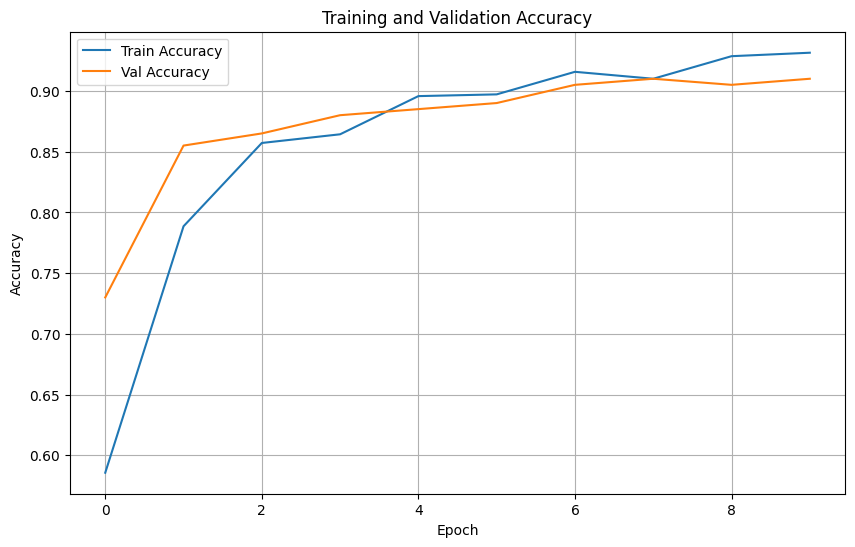

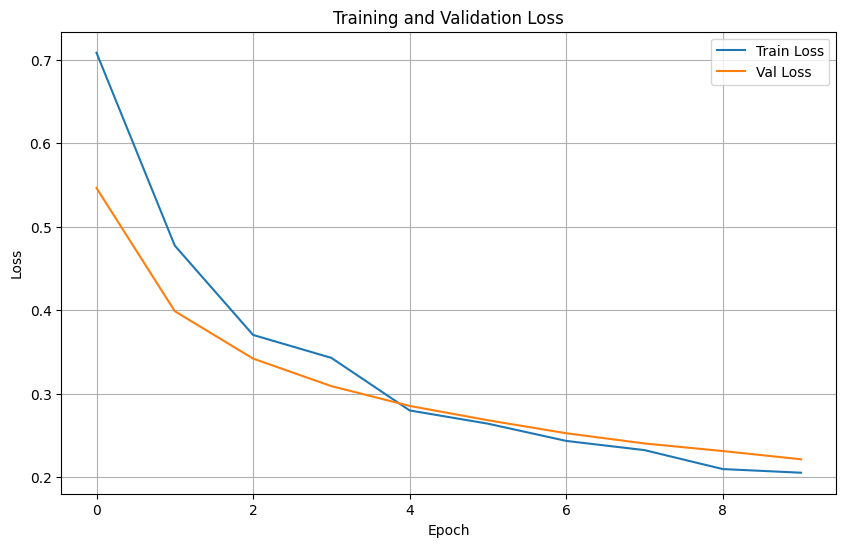

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Baca file log
log_df = pd.read_csv('training_log.csv')  # ganti sesuai nama file CSVLogger

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(log_df['epoch'], log_df['accuracy'], label='Train Accuracy')
plt.plot(log_df['epoch'], log_df['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(log_df['epoch'], log_df['loss'], label='Train Loss')
plt.plot(log_df['epoch'], log_df['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


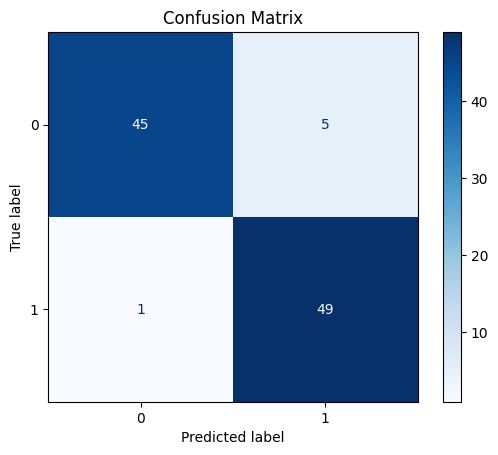

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.90      0.94        50
   Paralysis       0.91      0.98      0.94        50

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Ambil label dan prediksi dari test dataset
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy().flatten())
    y_pred.extend((preds >= 0.5).astype(int).flatten())  # thresholding sigmoid output

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
target_names = ['Normal', 'Paralysis']  # Sesuaikan nama kelas jika perlu
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))


In [11]:
model.save("final_modelYFPMEIIBINERaug1000.h5")  # Simpan dalam format HDF5

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [13]:
# Load model .h5
model = tf.keras.models.load_model('/kaggle/working/final_modelYFPMEIIBINERaug1000.h5')

In [14]:
# Daftar label (urutannya harus sama dengan saat training!)
class_names = ['Normal', 'Paralysis']

In [15]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np

# Contoh nama kelas
class_names = ['Normal', 'Paralysis']  # Ganti sesuai nama kelas Anda

def predict_image(img_path):
    # Load dan resize gambar
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess sesuai MobileNetV2
    img_array = preprocess_input(img_array)

    # Prediksi
    prediction = model.predict(img_array)
    predicted_class = int(prediction[0][0] >= 0.5)
    class_name = class_names[predicted_class]

    # Tampilkan gambar dan hasil prediksi
    plt.imshow(img)
    plt.title(f"Prediction: {class_name}")
    plt.axis('off')
    plt.show()

    return class_name


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


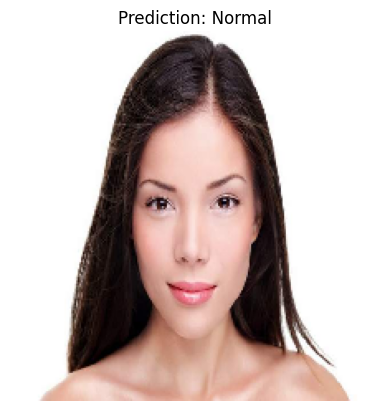

Hasil prediksi: Normal


In [16]:
hasil = predict_image('/kaggle/input/pasien-7/cara-mencerahkan-wajah-secara-alami-yang-lebih-efektif.jpg')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


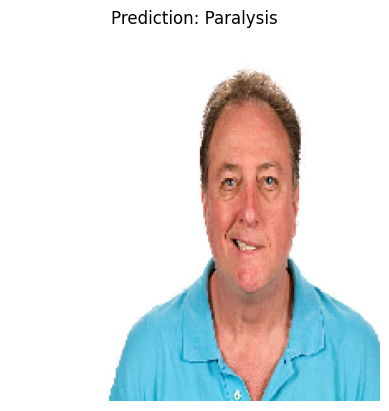

Hasil prediksi: Paralysis


In [17]:
hasil = predict_image('/kaggle/input/pasien/istockphoto-491702729-612x612.jpg')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


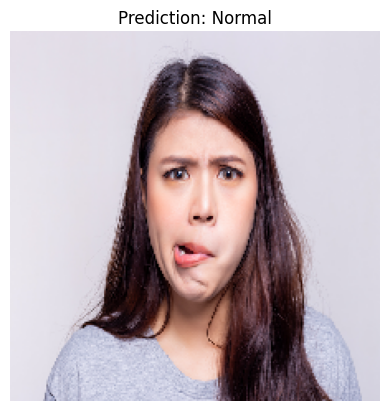

Hasil prediksi: Normal


In [18]:
hasil = predict_image('/kaggle/input/pasien/bells-palsy.png')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


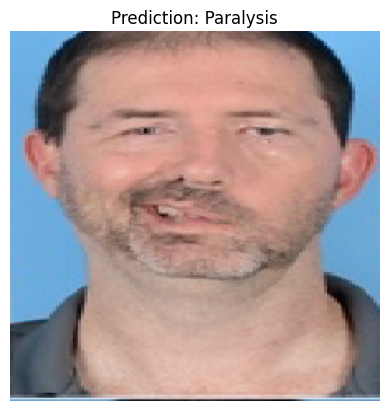

Hasil prediksi: Paralysis


In [19]:
hasil = predict_image('/kaggle/input/meii2kelas/Paralysis/CarouselMaker_ImageSplitter_29.png')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


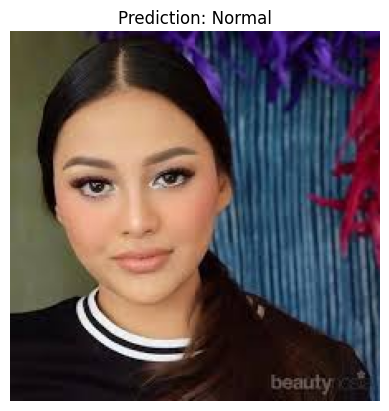

Hasil prediksi: Normal


In [20]:
hasil = predict_image('/kaggle/input/prediksi-biner/prediksi normal/1.jpeg')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


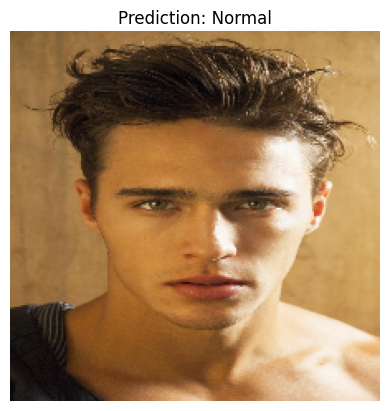

Hasil prediksi: Normal


In [21]:
hasil = predict_image('/kaggle/input/wajah-normal/1 (1024).jpg')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


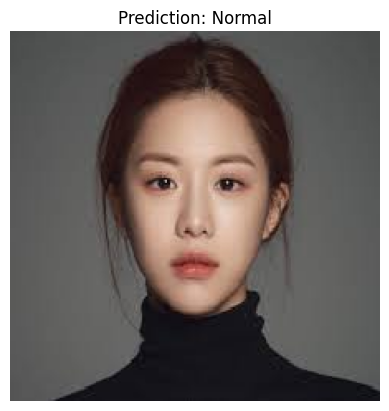

Hasil prediksi: Normal


In [22]:
hasil = predict_image('/kaggle/input/prediksi-biner/prediksi normal/2.jpeg')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


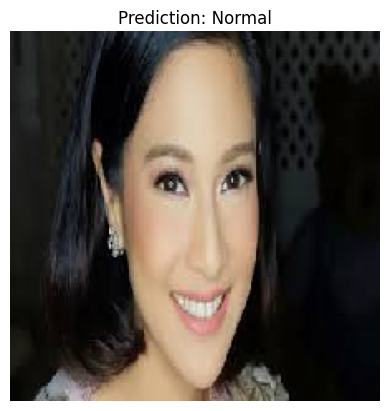

Hasil prediksi: Normal


In [23]:
hasil = predict_image('/kaggle/input/prediksi-biner/prediksi normal/4.jpeg')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


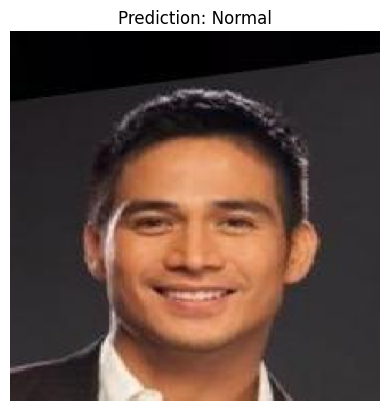

Hasil prediksi: Normal


In [24]:
hasil = predict_image('/kaggle/input/human-faces-dataset/Human Faces Dataset/Real Images/000012.jpg')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


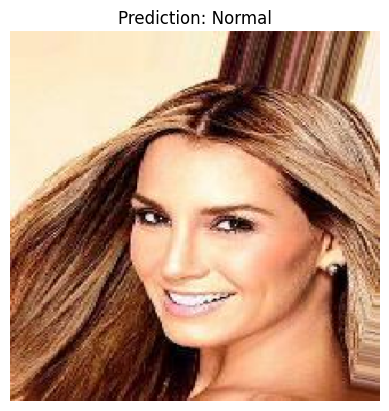

Hasil prediksi: Normal


In [25]:
hasil = predict_image('/kaggle/input/human-faces-dataset/Human Faces Dataset/Real Images/000001.jpg')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


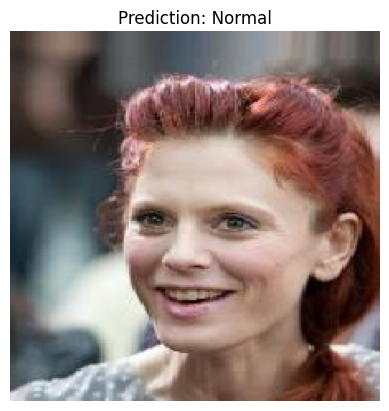

Hasil prediksi: Normal


In [26]:
hasil = predict_image('/kaggle/input/human-faces-dataset/Human Faces Dataset/Real Images/000002.jpg')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


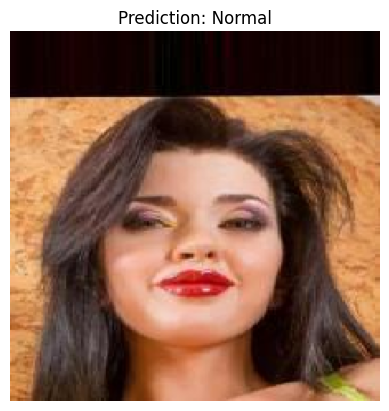

Hasil prediksi: Normal


In [27]:
hasil = predict_image('/kaggle/input/human-faces-dataset/Human Faces Dataset/Real Images/000078.jpg')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


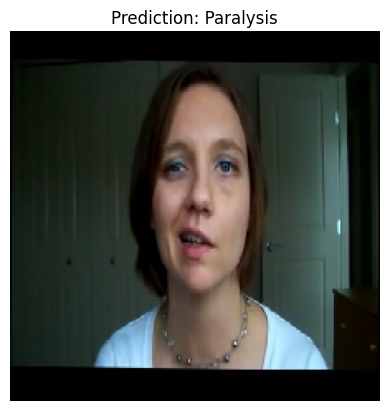

Hasil prediksi: Paralysis


In [28]:
hasil = predict_image('/kaggle/input/yfp-dataset-updated/Mouth/Mouth/Moderate severe mouth/15_M.S_mouth40.bmp')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


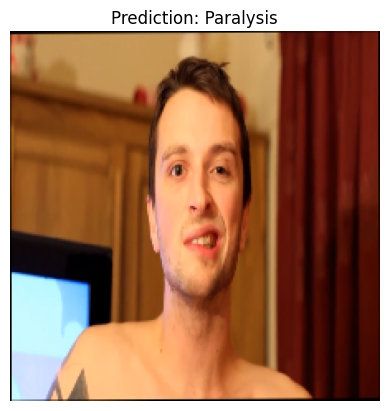

Hasil prediksi: Paralysis


In [29]:
hasil = predict_image('/kaggle/input/yfp-dataset-updated/Mouth/Mouth/Moderate severe mouth/17_M.S_mouth1.bmp')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


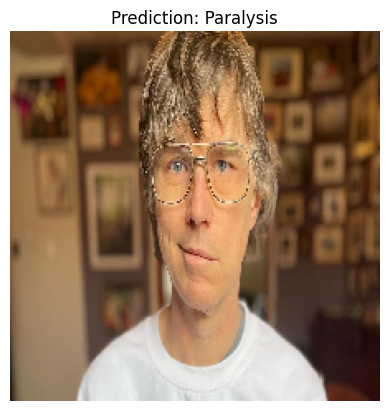

Hasil prediksi: Paralysis


In [30]:
hasil = predict_image('/kaggle/input/prediksi-biner/prediksi paralysis/3.jpg')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


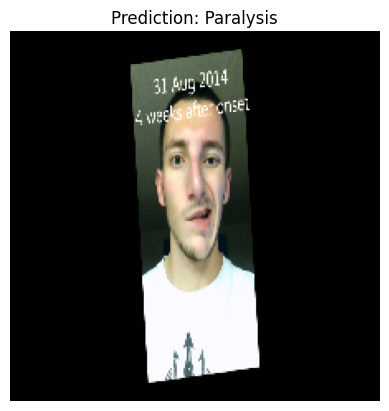

Hasil prediksi: Paralysis


In [31]:
hasil = predict_image('/kaggle/input/yfp-dataset-updated/Mouth/Mouth/Moderate severe mouth/16_M.S_mouth5.bmp')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


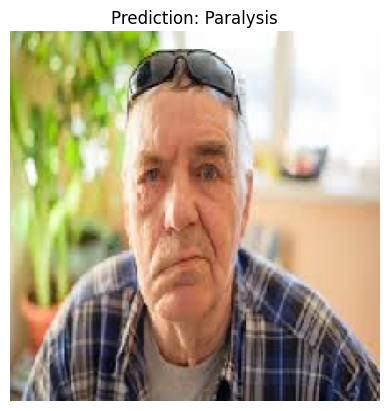

Hasil prediksi: Paralysis


In [32]:
hasil = predict_image('/kaggle/input/prediksi-biner/prediksi paralysis/4.jpeg')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


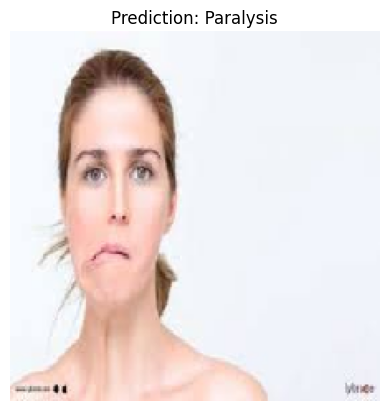

Hasil prediksi: Paralysis


In [33]:
hasil = predict_image('/kaggle/input/prediksi-biner/prediksi paralysis/1.jpeg')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


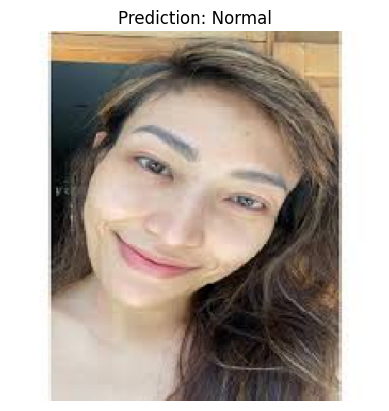

Hasil prediksi: Normal


In [34]:
hasil = predict_image('/kaggle/input/prediksi-biner/prediksi normal/3.jpeg')
print("Hasil prediksi:", hasil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


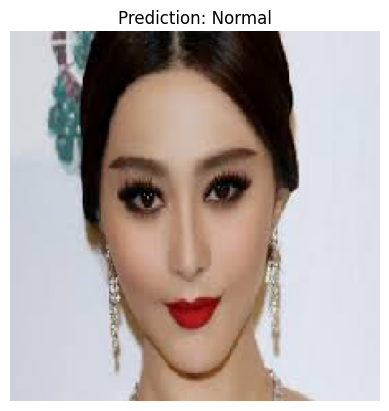

Hasil prediksi: Normal


In [35]:
hasil = predict_image('/kaggle/input/prediksi-biner/prediksi normal/5.jpeg')
print("Hasil prediksi:", hasil)